# Clustering cryptocurrencies based on closing prices

## Введение
Рынок криптовалют привлекает внимание инвесторов и исследователей благодаря высокой волатильности и потенциалу для прибыли. Кластеризация криптовалют на основе цен закрытия помогает выявить группы активов с похожей динамикой, что важно для принятия инвестиционных решений и изучения рыночной структуры. В данном исследовании мы применим методы кластерного анализа для группировки криптовалют и анализа полученных результатов.

## Описание входных данных
Для получения данных о криптовалютах мы воспользуемся библиотекой cryptocompare.  
Нам понадобится 4 функции из этой библиотеки:  
- get_coin_list(format=True) вернёт список всех криптовалют
- get_historical_price_day(value, currency="USD", limit=30) вернёт датафрейм с криптовалютами и информация о них в USD за последние 30 дней
- get_historical_price_hour(value, currency="USD", limit=3*24) вернёт датафрейм с криптовалютами и информация о них в USD за последние 72 часа(3 дня)
- get_historical_price_minute(value, currency="USD", limit=60) вернёт датафрейм с криптовалютами и информация о них в USD за последний час

## Цель
Найти такие криптовалюты, динамика цен закрытия которых отличается от биткоина(BTC)

## Подход к решению
Мы будем проводить классическую кластеризацию через вейвлет анализ и кластеризацию временных рядов с помощью метрики DTW(Dynamic Time Warping). Далее мы будем брать пересечение множеств валют отличных от кластера биткоина(BTC), тем самым мы будем более уверенными, что поведение цен закрытия валюты действительно отлично от биткоина(BTC), чем при использование одного из методов кластеризации.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cryptocompare as cr
import pywt

from scipy.fftpack import fft

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

Установим детерминированность

In [2]:
SEED = 0

Напишим функцию get_data(), которая будет принимать на вход список криптовалют, а на выходе возвращать три датафрейма, которые содержат информацию о криптовалютах за 30 дней, 72 часа, 60 минут

In [3]:
def get_data(crypto_values: list) -> tuple:
    """
    Get historical price data for a list of cryptocurrencies over different time periods.  
      
    Parametrs:  
    crypto_values (list): A list of cryptocurrency symbols for which to retrieve historical price data.
      
    Return:  
    tuple: A tuple containing three DataFrames:  
      - data_30days (pd.DataFrame): Historical price data for the last 30 days.  
      - data_72hours (pd.DataFrame): Historical price data for the last 72 hours.  
      - data_60minutes (pd.DataFrame): Historical price data for the last 60 minutes.
    """
    data_30days = pd.DataFrame()
    data_72hours = pd.DataFrame()
    data_60minutes = pd.DataFrame()

    for value in crypto_values:
        temp_df = pd.DataFrame(cr.get_historical_price_day(value, currency="USD", limit=30))
        temp_df['coin'] = value
        data_30days = pd.concat([data_30days,temp_df],ignore_index=True)

        temp_df = pd.DataFrame(cr.get_historical_price_hour(value, currency="USD", limit=3*24))
        temp_df['coin'] = value
        data_72hours = pd.concat([data_72hours,temp_df],ignore_index=True)

        temp_df = pd.DataFrame(cr.get_historical_price_minute(value, currency="USD", limit=60))
        temp_df['coin'] = value
        data_60minutes = pd.concat([data_60minutes,temp_df],ignore_index=True)

    return (data_30days, data_72hours, data_60minutes)

In [4]:
crypto_values = cr.get_coin_list(format=True)
data_30days, data_72hours, data_60minutes = get_data(crypto_values[:500])

[ERROR] CCCAGG market does not exist for this coin pair (HPC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (HPC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (HPC-USD)
[ERROR] CCCAGG market does not exist for this coin pair (TBIS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (TBIS-USD)
[ERROR] CCCAGG market does not exist for this coin pair (TBIS-USD)
Error getting coin information. HTTPSConnectionPool(host='min-api.cryptocompare.com', port=443): Max retries exceeded with url: /data/v2/histominute?fsym=BTS&tsym=USD&limit=60&e=CCCAGG&toTs=1723259261 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000204928009D0>, 'Connection to min-api.cryptocompare.com timed out. (connect timeout=None)'))
[ERROR] CCCAGG market does not exist for this coin pair (BTCD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BTCD-USD)
[ERROR] CCCAGG market does not exist for this coin pair (BTCD-USD)
[ERROR] CCCAGG market d

Так как у нас время представлено в unix-формате, приведем его к более удобному формату

In [5]:
data_30days['time'] = pd.to_datetime(data_30days['time'], unit='s')
data_72hours['time'] = pd.to_datetime(data_72hours['time'], unit='s')
data_60minutes['time'] = pd.to_datetime(data_60minutes['time'], unit='s')

Создадим сводные таблицы, где столбцы - криптовалюты, строки - цены закрытия

In [175]:
pivot_data_30days = pd.pivot_table(
    data=data_30days,
    columns='coin',
    index='time',
    values='close'
)

pivot_data_72hours = pd.pivot_table(
    data=data_72hours,
    columns='coin',
    index='time',
    values='close'
)

pivot_data_60_minutes = pd.pivot_table(
    data=data_60minutes,
    columns='coin',
    index='time',
    values='close'
)

Нормализуем наши ряды в диапазон от 0 до 1, так как у разных валют могут сильно отличаться цены закрытия

In [176]:
scaler = TimeSeriesScalerMinMax()

pivot_data_30days_scaled = pd.DataFrame(data=scaler.fit_transform(pivot_data_30days.T)[:,:,0].T,
                                         columns=pivot_data_30days.columns,
                                         index=pivot_data_30days.index)

pivot_data_72hours_scaled = pd.DataFrame(data=scaler.fit_transform(pivot_data_72hours.T)[:,:,0].T,
                                         columns=pivot_data_72hours.columns,
                                         index=pivot_data_72hours.index)

pivot_data_60minutes_scaled = pd.DataFrame(data=scaler.fit_transform(pivot_data_60_minutes.T)[:,:,0].T,
                                         columns=pivot_data_60_minutes.columns,
                                         index=pivot_data_60_minutes.index)

Напишем технические функции для визуализации цен закрытия валют

In [91]:
def get_vizualization_cryptovalues(pivot_data: pd.DataFrame) -> None:
    """
    Vizualize top 5 cryptovalues from pivot_data  
      
    Parametrs:  
    pivot_data (pd.DataFrame): Input data with shape (n_features, n_samples).
      
    Return:  
    None
    """
    fig, axes = plt.subplots(nrows=5,ncols=1, figsize=(15,10))

    for k in range(5):
        axes[k].plot(pivot_data[pivot_data.columns[k]])
        axes[k].set_title(pivot_data.columns[k])

    plt.tight_layout()
    fig.show()

def get_vizualization_results(pivot_data: pd.DataFrame, bitcoin: int, other: int, same_value: str, other_value: str) -> None:
    """
    Visualize the results of clustering analysis for Bitcoin and another cryptocurrency.

    Parametrs:  
    pivot_data (pd.DataFrame): Input data with shape (n_samples, n_features).  
    bitcoin (int): The cluster label for Bitcoin.  
    other (int): The cluster label for another cryptocurrency.  
    same_value (str): The name of the cryptocurrency in the same cluster as Bitcoin.  
    other_value (str): The name of the cryptocurrency in the other cluster.  
        
    Return:  
    None
    """
    cluster_bitcoin = pivot_data[pivot_data.Clusters==bitcoin].drop(columns=['Clusters'],axis=1).T.copy()
    plt.figure(figsize=(15,2))
    plt.plot(cluster_bitcoin['BTC'])
    plt.title('BTC')

    plt.figure(figsize=(15,2))
    plt.plot(cluster_bitcoin[same_value])
    plt.title(same_value)

    cluster_other = pivot_data_30days_scaled[pivot_data_30days_scaled.Clusters==other].drop(columns=['Clusters'],axis=1).T.copy()
    plt.figure(figsize=(15,2))
    plt.plot(cluster_other[other_value])
    plt.title(other_value)

Напишем технические функции для кластеризации через вейвлет анализ и DTW(Dynamic Time Warping)

In [92]:
def get_wavelet_features(pivot_data: pd.DataFrame) -> np.ndarray:
    """
    Get wavelet features
        
    Parametrs:  
    pivot_data (pd.DataFrame): Input data with shape (n_features, n_samples).
      
    Return:  
    np.ndarray: The wavelet features.
    """
    wavelet_features = []

    for col in pivot_data.columns:
        feature_wavelet = []

        coeffs = pywt.wavedec(pivot_data[col],'rbio3.1')
        for coeff in coeffs:
            feature_wavelet += list(coeff)
        wavelet_features.append(feature_wavelet)


    return np.array(wavelet_features)

def clustering_fit(data: np.ndarray, mode: str) -> tuple:
    """
    Perform clustering on the input data and evaluate the results using the elbow method and silhouette score.
        
    Parametrs:  
    data (np.ndarray): Input data with shape (n_samples, n_features).   
    mode (str): The clustering mode, either 'wavelet' for KMeans or 'dtw' for TimeSeriesKMeans.  
      
    Return:  
    tuple: A tuple containing two lists:      
      - inertians (list): A list of inertia values for each k.  
      - silhouette_arr (list) A list of silhouette scores for each k.  
    """
    inertians = []
    silhouette_arr = []

    K=range(2,7)

    for k in K:
        if mode=='wavelet':
            model = KMeans(n_clusters=k, random_state= SEED)
        elif mode=='dtw':
            model = TimeSeriesKMeans(n_clusters=k,metric='dtw', n_jobs=12 , random_state= SEED)
        
        model.fit(data)

        inertia = model.inertia_

        inertians.append(inertia)
        silhouette_arr.append(silhouette_score(data, model.labels_))

    plt.figure(figsize=(10,5))
    plt.plot(K,inertians,'gx-')
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Метод локтя')

    plt.figure(figsize=(10,5))
    plt.plot(K,silhouette_arr,'gx-')
    plt.xlabel('k')
    plt.ylabel('silhouette')
    plt.title('Ширина силуэта')

    return (inertians, silhouette_arr)

Напишем технические функции для уменьшения размерности данных и их визуализации

In [173]:
def get_transform(pivot_data: pd.DataFrame) -> np.ndarray:
    """
    Transform with PCA + t-SNE.     
            
    Parametrs:    
    pivot_data (pd.DataFrame): (n_features, n_samples).      
        
    Return:      
    np.ndarray: The transformed data after applying PCA and t-SNE.
    """
    n_components = min(15, len(pivot_data.columns))
    pca = PCA(n_components=n_components)
    pca_transormed = pca.fit_transform(pivot_data.T)
    
    perplexity = min(30, len(pivot_data.columns)-1)
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsne_transformed = tsne.fit_transform(pca_transormed)

    return tsne_transformed

def get_vizualization_transform(data_transformed: np.ndarray, clusters: np.ndarray) -> None:
    """
    Vizualize the transformed data after applying PCA and t-SNE.  
        
    Parametrs:  
    data_transformed (np.ndarray): (n_samples, n_components).  
    clusters (np.ndarray): cluster labels for each data point.
      
    Return:  
    None
    """
    fig = plt.scatter(data_transformed[:,0],data_transformed[:,1], c=clusters)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('PCA+t-SNE vizualization')
    plt.legend(*fig.legend_elements(), title='Clusters', bbox_to_anchor=(1.17, 0.5), loc='right')
    plt.tight_layout()

<h2>30 days</h2>

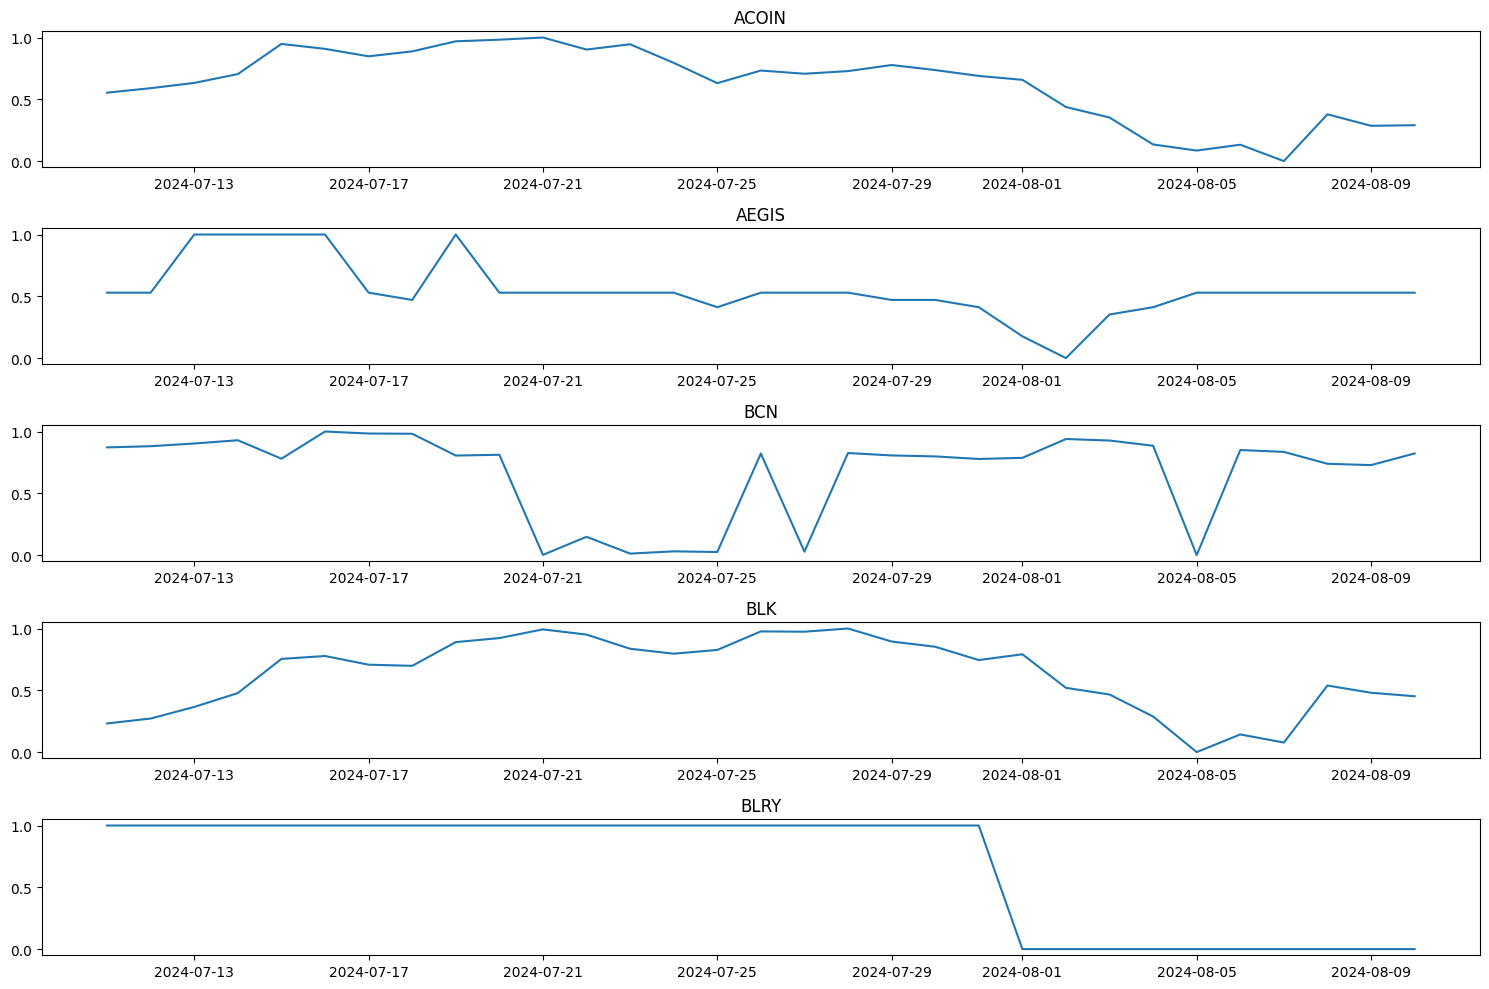

In [177]:
get_vizualization_cryptovalues(pivot_data_30days_scaled)

### Clustering with furier

Была проведена попытка получить признаки через преобразование Фурье, но не было хорошо выделенных пиков, только небольшие колебания, либо просто прямая линия. Поэтому было принято решение использовать вейвлет анализ для извлечения признаков как для "30 дней", так и для "72 часа" и "60 минут".

In [46]:
# # # for furier

# Fs = 1.0 # 1 отсчет в день
# T = 1/Fs # период 1 день

In [50]:
# fft_values = fft(pivot_data_30days['BTC'].values)
# plt.plot(np.linspace(0,Fs/2, len(fft_values)//2),2/len(fft_values)*np.abs(fft_values[:len(fft_values)//2]))

In [43]:
# fft_values = fft(pivot_data_72hours['BTC'].values)
# plt.plot(np.linspace(0,Fs/2, len(fft_values)//2),2/len(fft_values)*np.abs(fft_values[:len(fft_values)//2]))

In [48]:
# fft_values = fft(pivot_data_60_minutes['BTC'].values)
# plt.plot(np.linspace(0,Fs/2, len(fft_values)//2),2/len(fft_values)*np.abs(fft_values[:len(fft_values)//2]))

### Clustering with wavelet

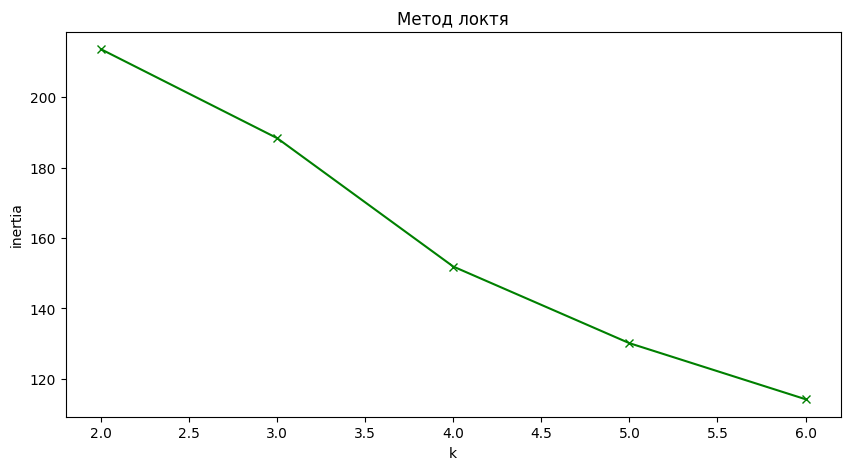

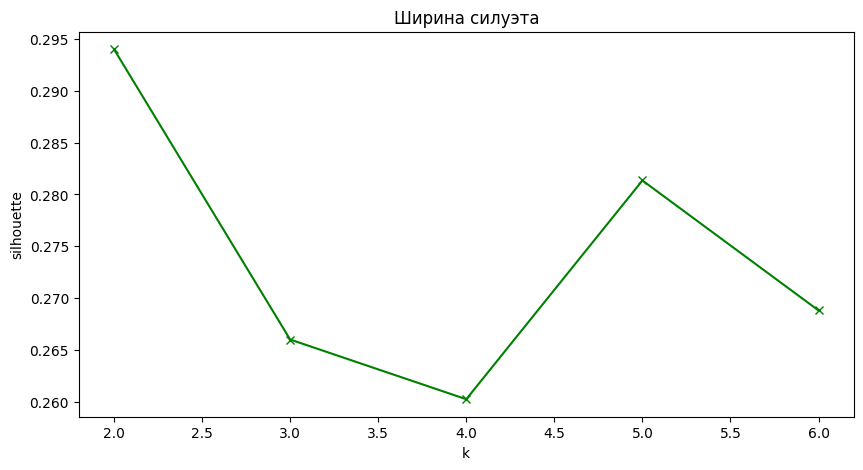

In [178]:
wavelet_features = get_wavelet_features(pivot_data_30days_scaled)
inertians, silhouette_arr = clustering_fit(data=wavelet_features, mode='wavelet')

Лучшим решением будет разбиение на 5 кластеров, так как ширина силуэта гораздо больше чем на 3 и 4 кластерах и инерция будет также меньше

In [96]:
wavelet_features.shape

(68, 39)

In [179]:
model = KMeans(n_clusters=5, random_state= SEED)
clusters = model.fit_predict(wavelet_features)

Применим PCA + t-SNE для визуализации наших кластеров в двумерном пространстве

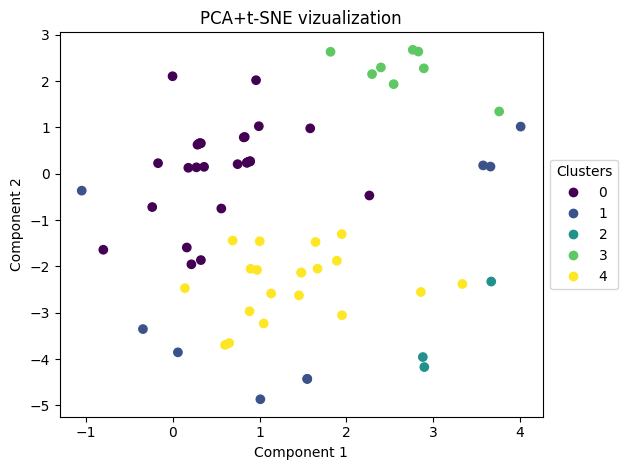

In [181]:
data_transormed = get_transform(pivot_data=pivot_data_30days_scaled)
get_vizualization_transform(data_transformed=data_transormed,clusters=clusters)

In [182]:
pivot_data_30days_scaled_w = pivot_data_30days_scaled.T.copy()
pivot_data_30days_scaled_w['Clusters'] = clusters

Валюты, которые попали в кластеры отличные от кластера с биткоином

In [183]:
pivot_data_30days_scaled_w.T[['BTC']].T

time,2024-07-11 00:00:00,2024-07-12 00:00:00,2024-07-13 00:00:00,2024-07-14 00:00:00,2024-07-15 00:00:00,2024-07-16 00:00:00,2024-07-17 00:00:00,2024-07-18 00:00:00,2024-07-19 00:00:00,2024-07-20 00:00:00,...,2024-08-02 00:00:00,2024-08-03 00:00:00,2024-08-04 00:00:00,2024-08-05 00:00:00,2024-08-06 00:00:00,2024-08-07 00:00:00,2024-08-08 00:00:00,2024-08-09 00:00:00,2024-08-10 00:00:00,Clusters
coin,,,,,,,,,,,,,,,,,,,,,
BTC,0.233243,0.272968,0.365605,0.477251,0.754784,0.777431,0.707747,0.699646,0.891409,0.92343,...,0.51969,0.467442,0.288594,0.0,0.142456,0.077254,0.539818,0.480774,0.4511,0.0


In [184]:
pivot_data_30days_scaled_w[pivot_data_30days_scaled_w.Clusters != 0].index

Index(['ACOIN', 'AEGIS', 'BCN', 'BLRY', 'BSTY', 'BTS', 'CAB', 'CHIP', 'CSC',
       'DCR', 'DGB', 'DIAM', 'ETC', 'ETH', 'EXP', 'GLC', 'GRS', 'HNC', 'LTC',
       'MAID', 'MONA', 'NAV', 'NMC', 'NXT', 'PAK', 'PINK', 'RDD', 'RDN', 'REP',
       'STEEM', 'SYS', 'TWT', 'VAL', 'VTC', 'WAVES', 'XBC', 'XDN', 'XEM',
       'XMR', 'ZEC'],
      dtype='object', name='coin')

### Clustering with DTW

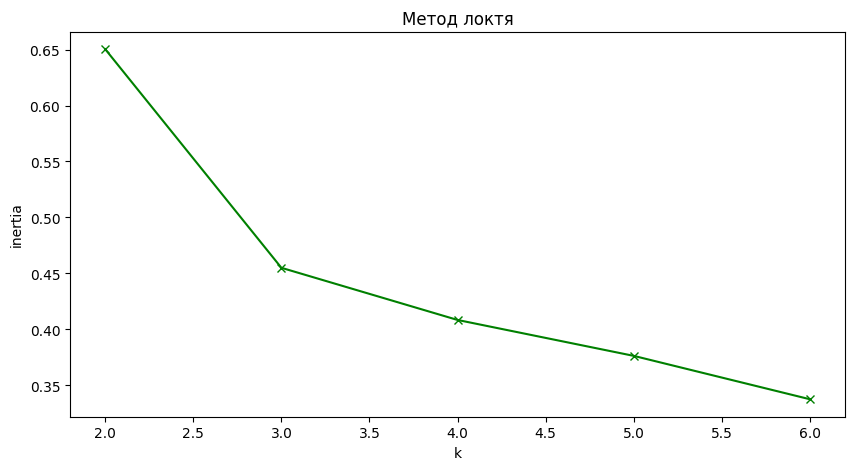

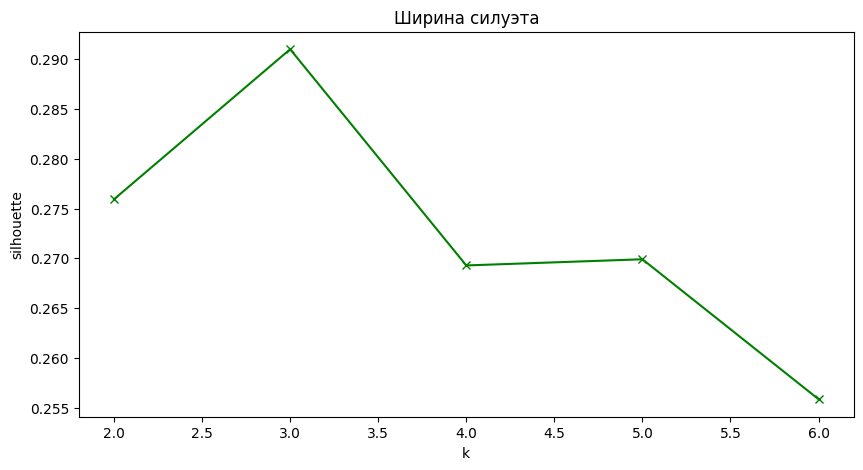

In [185]:
inertians, silhouette_arr = clustering_fit(data=pivot_data_30days_scaled.T, mode='dtw')

Оптимальное количество кластеров будет 3, так ширина силуэта наибольшая и есть хороший изгиб на графике "Метод локтя"

In [186]:
model = TimeSeriesKMeans(n_clusters=3,metric='dtw', n_jobs=12 , random_state= SEED)
clusters = model.fit_predict(pivot_data_30days_scaled.T)

In [187]:
clusters

array([0, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 0,
       1, 1], dtype=int64)

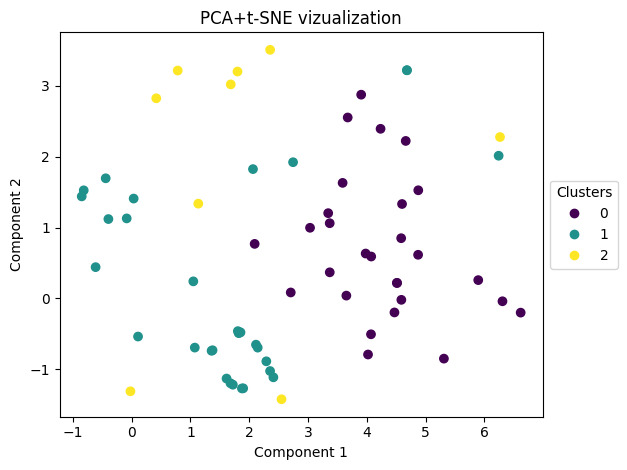

In [189]:
data_transormed = get_transform(pivot_data=pivot_data_30days_scaled)
get_vizualization_transform(data_transformed=data_transormed,clusters=clusters)

In [190]:
pivot_data_30days_scaled_dtw = pivot_data_30days_scaled.T.copy()
pivot_data_30days_scaled_dtw['Clusters'] = clusters

Валюты, которые попали в кластеры отличные от кластера с биткоином

In [191]:
pivot_data_30days_scaled_dtw.T[['BTC']].T

time,2024-07-11 00:00:00,2024-07-12 00:00:00,2024-07-13 00:00:00,2024-07-14 00:00:00,2024-07-15 00:00:00,2024-07-16 00:00:00,2024-07-17 00:00:00,2024-07-18 00:00:00,2024-07-19 00:00:00,2024-07-20 00:00:00,...,2024-08-02 00:00:00,2024-08-03 00:00:00,2024-08-04 00:00:00,2024-08-05 00:00:00,2024-08-06 00:00:00,2024-08-07 00:00:00,2024-08-08 00:00:00,2024-08-09 00:00:00,2024-08-10 00:00:00,Clusters
coin,,,,,,,,,,,,,,,,,,,,,
BTC,0.233243,0.272968,0.365605,0.477251,0.754784,0.777431,0.707747,0.699646,0.891409,0.92343,...,0.51969,0.467442,0.288594,0.0,0.142456,0.077254,0.539818,0.480774,0.4511,1.0


In [192]:
pivot_data_30days_scaled_dtw[pivot_data_30days_scaled_dtw.Clusters!=1].index

Index(['ACOIN', 'BCN', 'BLRY', 'BSTY', 'BTS', 'CAB', 'CHIP', 'CSC', 'DASH',
       'DCR', 'DGB', 'DOGE', 'ETC', 'ETH', 'EXP', 'GLC', 'GRS', 'LSK', 'LTC',
       'MAID', 'MONA', 'NAV', 'PAK', 'PINK', 'RDN', 'REP', 'SC', 'SIGNA',
       'STEEM', 'SYS', 'TWT', 'VAL', 'XBC', 'XCP', 'XDN', 'XMR', 'XVG'],
      dtype='object', name='coin')

### Итого за 30 дней

In [194]:
set1 = set(pivot_data_30days_scaled_dtw[pivot_data_30days_scaled_dtw.Clusters!=1].index)
set2 = set(pivot_data_30days_scaled_w[pivot_data_30days_scaled_w.Clusters != 0].index)

intersection = len(set1 & set2)
union = len(set1 | set2)

intersection / union

0.6382978723404256

Кластеризации через вейвлет анализ и dtw показали, средние результаты, то есть валюты, которые попали в кластеры отличные от кластера BTC, неплохо совпадают в множествах. Разница в том, что вейвлет анализ предлагает разбить валюты на 5 кластеров, а dtw на 3 кластера(вывод можно сделать из графиков).  
  
Выведем пересечение множеств

In [195]:
set1 & set2

{'ACOIN',
 'BCN',
 'BLRY',
 'BSTY',
 'BTS',
 'CAB',
 'CHIP',
 'CSC',
 'DCR',
 'DGB',
 'ETC',
 'ETH',
 'EXP',
 'GLC',
 'GRS',
 'LTC',
 'MAID',
 'MONA',
 'NAV',
 'PAK',
 'PINK',
 'RDN',
 'REP',
 'STEEM',
 'SYS',
 'TWT',
 'VAL',
 'XBC',
 'XDN',
 'XMR'}

## 72 hours

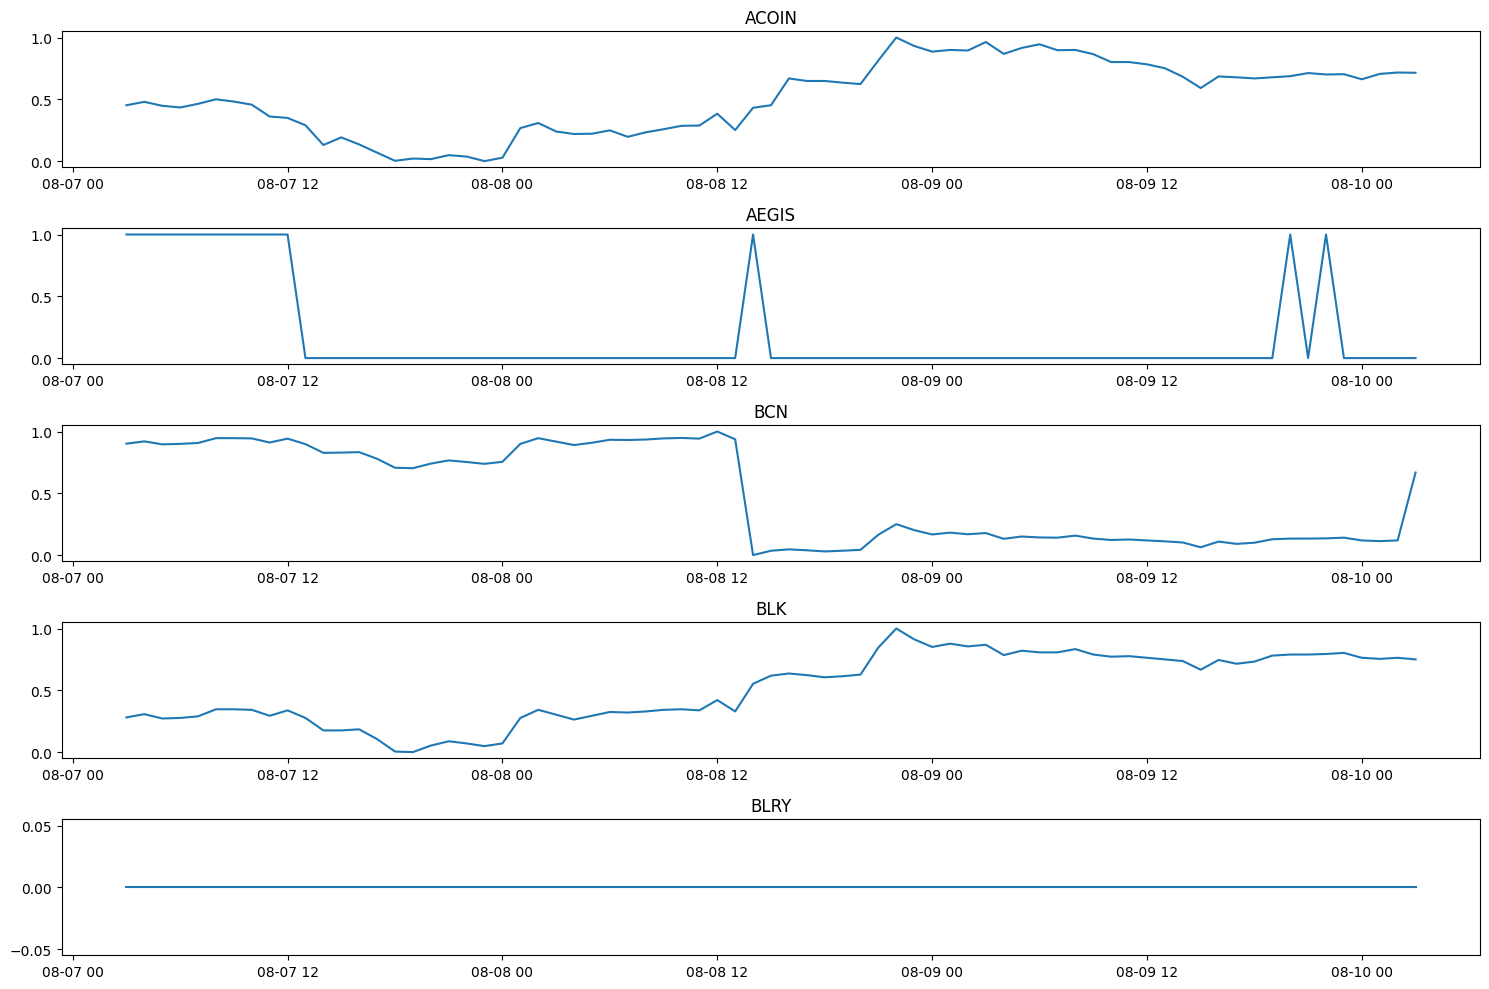

In [198]:
get_vizualization_cryptovalues(pivot_data_72hours_scaled)

### Clustering with wavelet

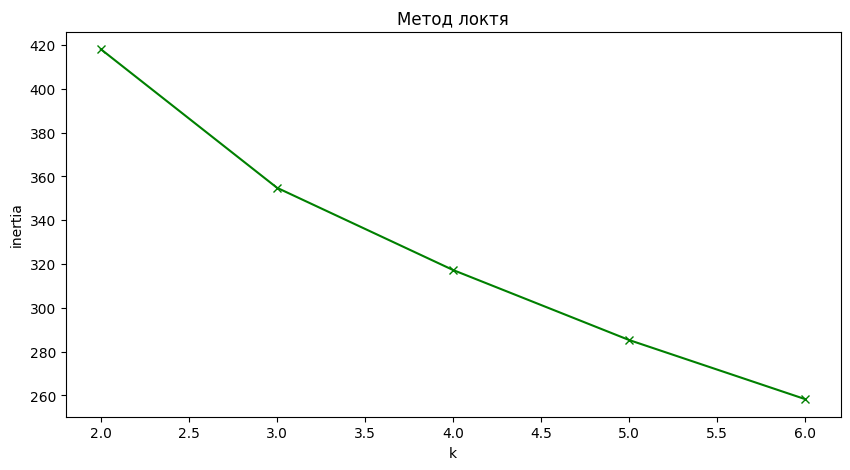

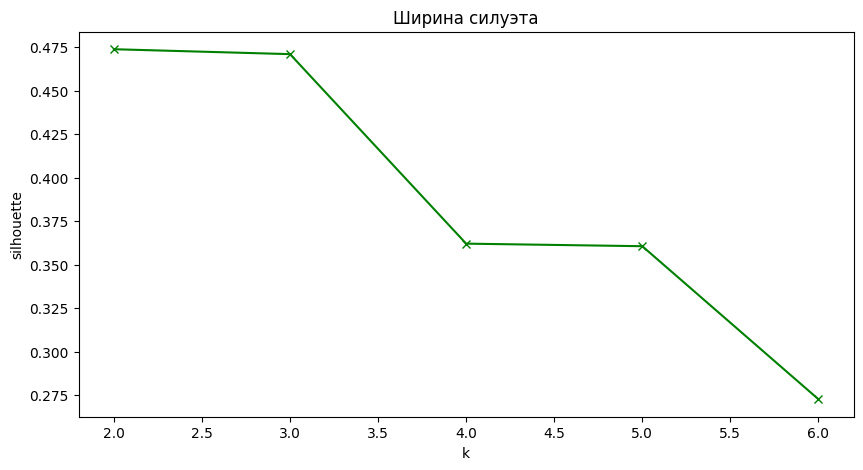

In [201]:
wavelet_features = get_wavelet_features(pivot_data_72hours_scaled)
inertians, silhouette_arr = clustering_fit(data=wavelet_features, mode='wavelet')

Оптимальное число кластеров равно 3, так как ширина силуэта далее начинает сильно уменьшаться

In [202]:
model = KMeans(n_clusters=3, random_state= SEED)
clusters = model.fit_predict(wavelet_features)

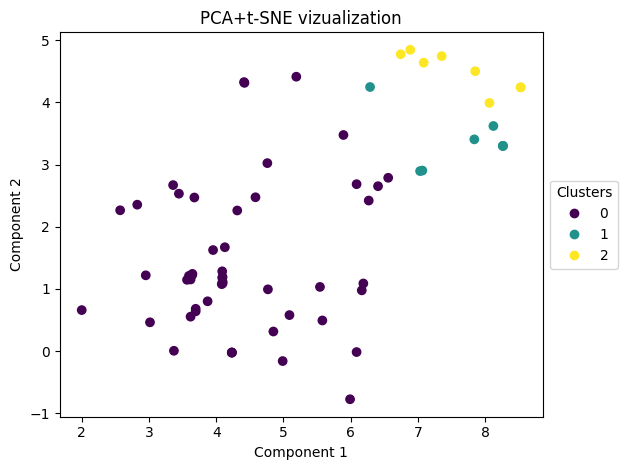

In [204]:
data_transormed = get_transform(pivot_data=pivot_data_72hours_scaled)
get_vizualization_transform(data_transformed=data_transormed,clusters=clusters)

In [205]:
pivot_data_72hours_scaled_w = pivot_data_72hours_scaled.T.copy()
pivot_data_72hours_scaled_w['Clusters'] = clusters

Валюты, которые попали в кластеры отличные от кластера с биткоином

In [206]:
pivot_data_72hours_scaled_w.T[['BTC']].T

time,2024-08-07 03:00:00,2024-08-07 04:00:00,2024-08-07 05:00:00,2024-08-07 06:00:00,2024-08-07 07:00:00,2024-08-07 08:00:00,2024-08-07 09:00:00,2024-08-07 10:00:00,2024-08-07 11:00:00,2024-08-07 12:00:00,...,2024-08-09 19:00:00,2024-08-09 20:00:00,2024-08-09 21:00:00,2024-08-09 22:00:00,2024-08-09 23:00:00,2024-08-10 00:00:00,2024-08-10 01:00:00,2024-08-10 02:00:00,2024-08-10 03:00:00,Clusters
coin,,,,,,,,,,,,,,,,,,,,,
BTC,0.282268,0.306739,0.272883,0.277562,0.289108,0.345033,0.345317,0.342933,0.294167,0.338135,...,0.781873,0.790765,0.790906,0.794798,0.80385,0.76444,0.754144,0.763521,0.748286,0.0


In [207]:
pivot_data_72hours_scaled_w[pivot_data_72hours_scaled_w.Clusters!=0].index

Index(['AEGIS', 'BCN', 'BLRY', 'BTS', 'CAB', 'EXP', 'GEO', 'GLC', 'HNC',
       'PINK', 'PPC', 'RDD', 'RDN', 'REP', 'XCP', 'XDN'],
      dtype='object', name='coin')

### Clustering with DTW

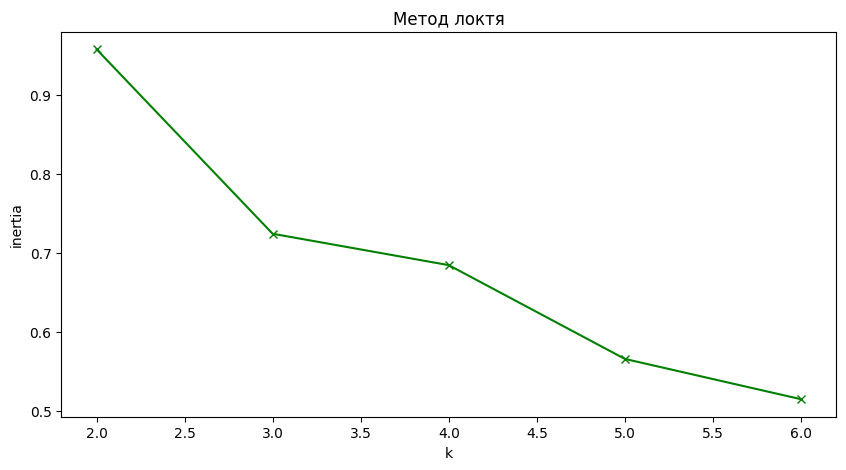

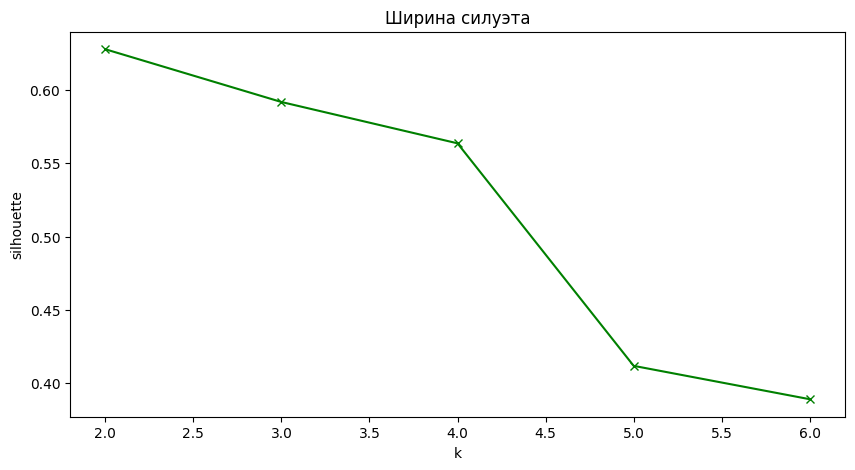

In [209]:
inertians, silhouette_arr = clustering_fit(data=pivot_data_72hours_scaled.T, mode='dtw')

По моему мнению, в данном случае оптимальное число кластеров равно 3, так как виден хороший изгиб на первом графике, а ширина силуэта по мере увеличения кластеров будет уменьшаться

In [210]:
model = TimeSeriesKMeans(n_clusters=3,metric='dtw', n_jobs=12 , random_state= SEED)
clusters = model.fit_predict(pivot_data_72hours_scaled.T)

In [211]:
clusters

array([1, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1,
       1], dtype=int64)

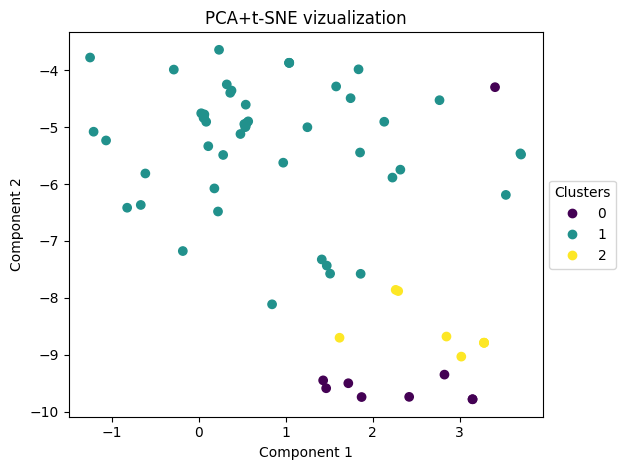

In [213]:
data_transormed = get_transform(pivot_data=pivot_data_72hours_scaled)
get_vizualization_transform(data_transformed=data_transormed,clusters=clusters)

In [214]:
pivot_data_72hours_scaled_dtw = pivot_data_72hours_scaled.T.copy()
pivot_data_72hours_scaled_dtw['Clusters'] = clusters

Валюты, которые попали в кластеры отличные от кластера с биткоином

In [215]:
pivot_data_72hours_scaled_dtw.T[['BTC']].T

time,2024-08-07 03:00:00,2024-08-07 04:00:00,2024-08-07 05:00:00,2024-08-07 06:00:00,2024-08-07 07:00:00,2024-08-07 08:00:00,2024-08-07 09:00:00,2024-08-07 10:00:00,2024-08-07 11:00:00,2024-08-07 12:00:00,...,2024-08-09 19:00:00,2024-08-09 20:00:00,2024-08-09 21:00:00,2024-08-09 22:00:00,2024-08-09 23:00:00,2024-08-10 00:00:00,2024-08-10 01:00:00,2024-08-10 02:00:00,2024-08-10 03:00:00,Clusters
coin,,,,,,,,,,,,,,,,,,,,,
BTC,0.282268,0.306739,0.272883,0.277562,0.289108,0.345033,0.345317,0.342933,0.294167,0.338135,...,0.781873,0.790765,0.790906,0.794798,0.80385,0.76444,0.754144,0.763521,0.748286,1.0


In [216]:
pivot_data_72hours_scaled_dtw[pivot_data_72hours_scaled_dtw.Clusters!=1].index

Index(['AEGIS', 'BCN', 'BLRY', 'BTS', 'CAB', 'EXP', 'GEO', 'GLC', 'HNC', 'NAV',
       'PINK', 'PPC', 'RDD', 'RDN', 'REP', 'XCP', 'XDN'],
      dtype='object', name='coin')

### Итого за 72 часа

In [217]:
set1 = set(pivot_data_72hours_scaled_dtw[pivot_data_72hours_scaled_dtw.Clusters!=1].index)
set2 = set(pivot_data_72hours_scaled_w[pivot_data_72hours_scaled_w.Clusters != 0].index)

intersection = len(set1 & set2)
union = len(set1 | set2)

intersection / union

0.9411764705882353

Тут уже наши множества, можно сказать, идентичны. Вейвлет анализ и dtw показали очень близкий результат. Они нашли почти одни и те же валюты, которые отличаются поведением от биткоина, а также оба предложили разбить наши ряды на 3 кластера.  
  
Выведем пересечение множеств

In [218]:
set1 & set2

{'AEGIS',
 'BCN',
 'BLRY',
 'BTS',
 'CAB',
 'EXP',
 'GEO',
 'GLC',
 'HNC',
 'PINK',
 'PPC',
 'RDD',
 'RDN',
 'REP',
 'XCP',
 'XDN'}

## 60 minutes

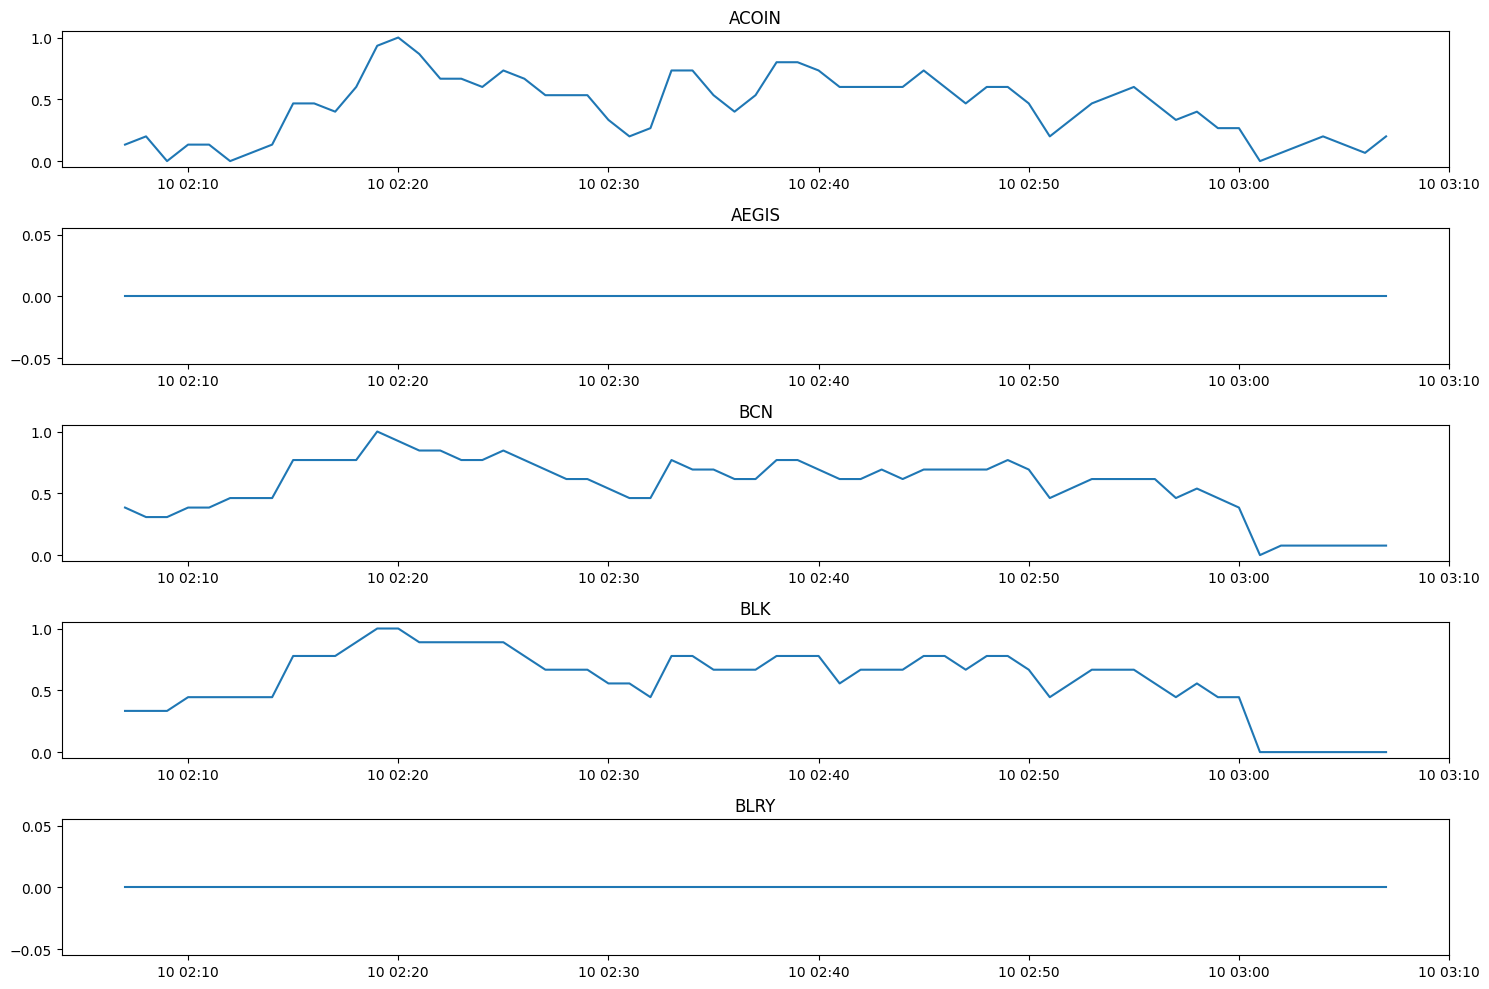

In [219]:
get_vizualization_cryptovalues(pivot_data_60minutes_scaled)

### Clustering with wavelet

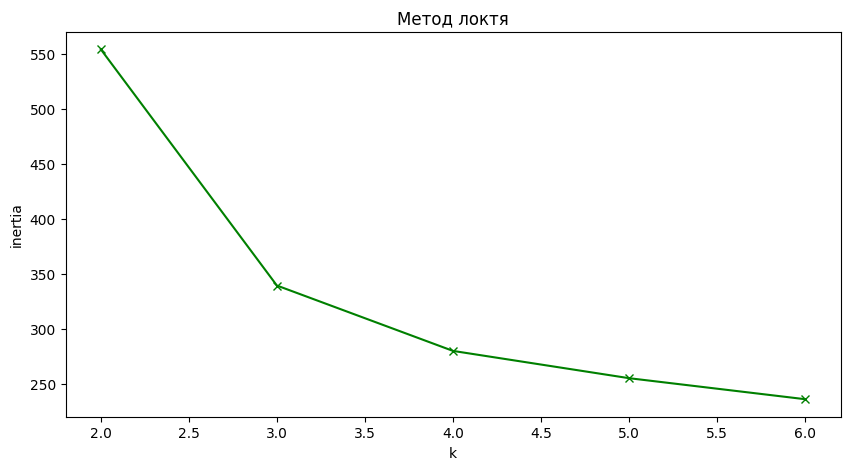

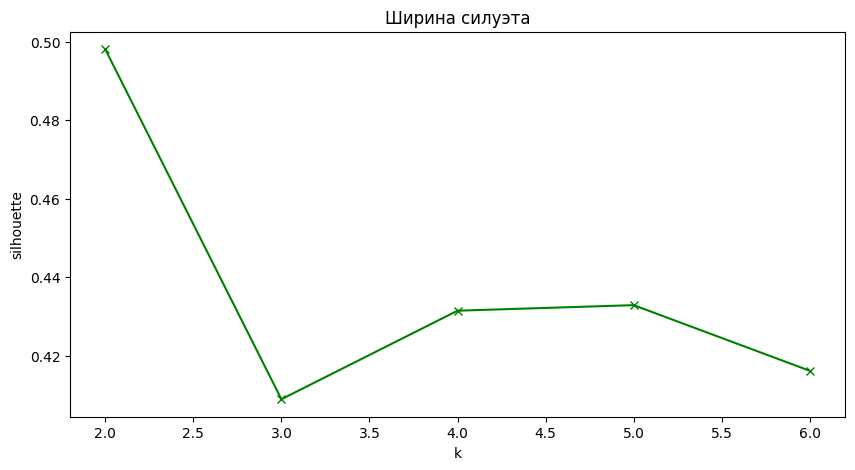

In [249]:
wavelet_features = get_wavelet_features(pivot_data_60minutes_scaled)
inertians, silhouette_arr = clustering_fit(data=wavelet_features, mode='wavelet')

Не смотря на то, что есть изгиб на графике "Метод локтя" при разбиении на 3 кластера, ширина силуэта будет выше на 5 кластерах, следовательно инерция тоже меньше будет, поэтому оптимальным числом количества кластеров будет 5

In [251]:
model = KMeans(n_clusters=5, random_state= SEED)
clusters = model.fit_predict(wavelet_features)

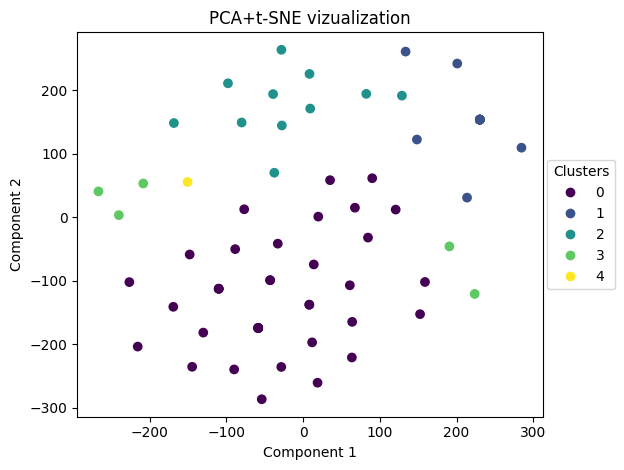

In [235]:
data_transormed = get_transform(pivot_data=pivot_data_60minutes_scaled)
get_vizualization_transform(data_transformed=data_transormed,clusters=clusters)

In [252]:
pivot_data_60minutes_scaled_w = pivot_data_60minutes_scaled.T.copy()
pivot_data_60minutes_scaled_w['Clusters'] = clusters

Валюты, которые попали в кластеры отличные от кластера с биткоином

In [253]:
pivot_data_60minutes_scaled_w.T[['BTC']].T

time,2024-08-10 02:07:00,2024-08-10 02:08:00,2024-08-10 02:09:00,2024-08-10 02:10:00,2024-08-10 02:11:00,2024-08-10 02:12:00,2024-08-10 02:13:00,2024-08-10 02:14:00,2024-08-10 02:15:00,2024-08-10 02:16:00,...,2024-08-10 02:59:00,2024-08-10 03:00:00,2024-08-10 03:01:00,2024-08-10 03:02:00,2024-08-10 03:03:00,2024-08-10 03:04:00,2024-08-10 03:05:00,2024-08-10 03:06:00,2024-08-10 03:07:00,Clusters
coin,,,,,,,,,,,,,,,,,,,,,
BTC,0.359995,0.314025,0.289224,0.381361,0.402761,0.441333,0.460982,0.474522,0.746937,0.806116,...,0.416763,0.380106,0.0,0.020904,0.039067,0.037978,0.023117,0.007034,0.023348,0.0


In [254]:
pivot_data_60minutes_scaled_w[pivot_data_60minutes_scaled_w.Clusters!=0].index

Index(['AEGIS', 'BLRY', 'BSTY', 'CAB', 'CSC', 'DASH', 'DCR', 'DGB', 'DIAM',
       'GLC', 'LSK', 'MONA', 'NAV', 'PAK', 'PINK', 'PPC', 'RDD', 'REP', 'SC',
       'STEEM', 'SYS', 'TWT', 'VTC', 'WAVES', 'XEM', 'XLM', 'XRP', 'XVG',
       'ZEC'],
      dtype='object', name='coin')

### Clustering with DTW

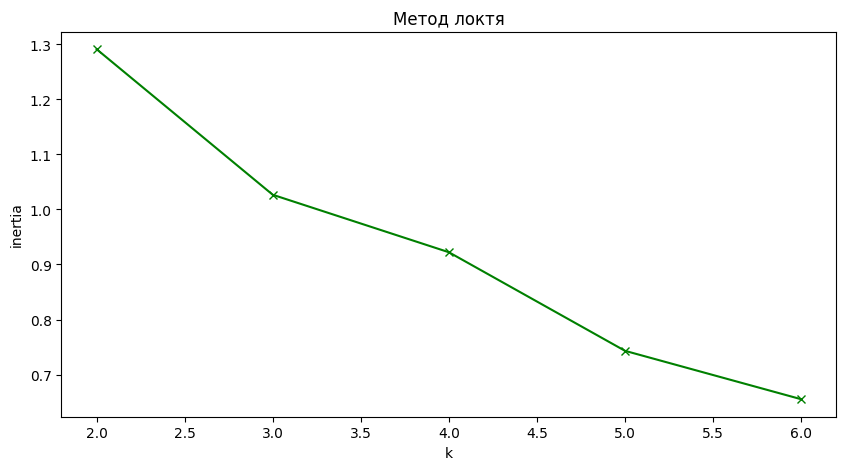

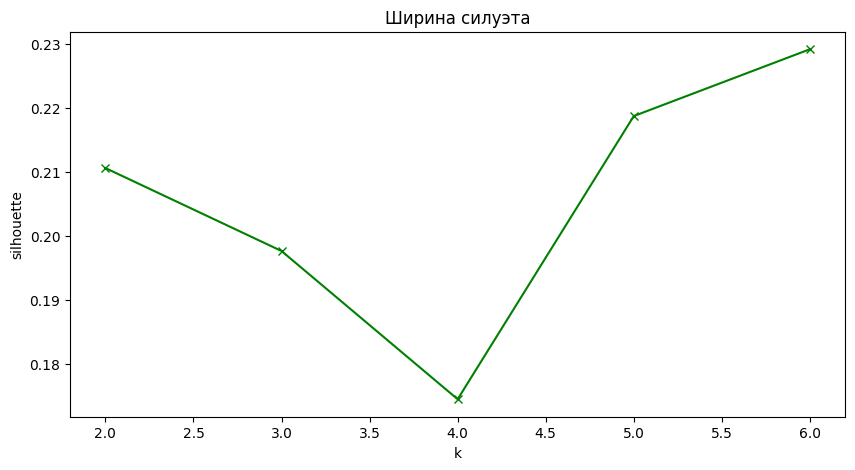

In [241]:
inertians, silhouette_arr = clustering_fit(data=pivot_data_60minutes_scaled, mode='dtw')

Тут наилучшим варинтом будет разбиение на 6 кластеров

In [242]:
model = TimeSeriesKMeans(n_clusters=6,metric='dtw', n_jobs=12 , random_state= SEED)
clusters = model.fit_predict(pivot_data_60minutes_scaled.T)

In [243]:
clusters

array([1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 3, 5, 2, 5, 1, 5, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 4, 2, 1, 4, 2, 1, 0,
       0, 1, 1, 1, 5, 4, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 4, 5, 1, 5, 4, 1,
       5], dtype=int64)

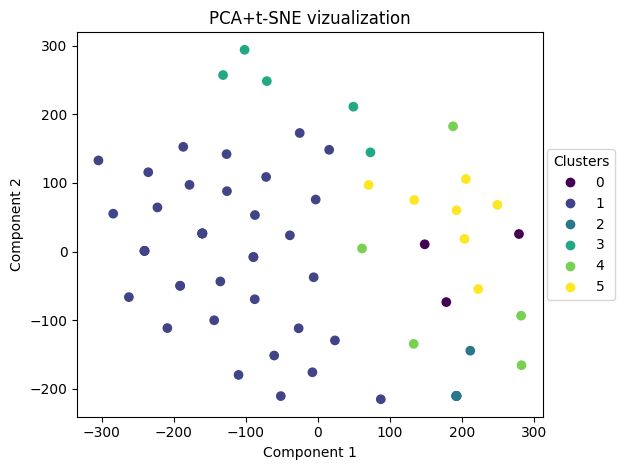

In [244]:
data_transormed = get_transform(pivot_data=pivot_data_60minutes_scaled)
get_vizualization_transform(data_transformed=data_transormed,clusters=clusters)

In [245]:
pivot_data_60minutes_scaled_dtw = pivot_data_60minutes_scaled.T.copy()
pivot_data_60minutes_scaled_dtw['Clusters'] = clusters

Валюты, которые попали в кластеры отличные от кластера с биткоином

In [246]:
pivot_data_60minutes_scaled_dtw.T[['BTC']].T

time,2024-08-10 02:07:00,2024-08-10 02:08:00,2024-08-10 02:09:00,2024-08-10 02:10:00,2024-08-10 02:11:00,2024-08-10 02:12:00,2024-08-10 02:13:00,2024-08-10 02:14:00,2024-08-10 02:15:00,2024-08-10 02:16:00,...,2024-08-10 02:59:00,2024-08-10 03:00:00,2024-08-10 03:01:00,2024-08-10 03:02:00,2024-08-10 03:03:00,2024-08-10 03:04:00,2024-08-10 03:05:00,2024-08-10 03:06:00,2024-08-10 03:07:00,Clusters
coin,,,,,,,,,,,,,,,,,,,,,
BTC,0.359995,0.314025,0.289224,0.381361,0.402761,0.441333,0.460982,0.474522,0.746937,0.806116,...,0.416763,0.380106,0.0,0.020904,0.039067,0.037978,0.023117,0.007034,0.023348,1.0


In [247]:
pivot_data_60minutes_scaled_dtw[pivot_data_60minutes_scaled_dtw.Clusters!=1].index

Index(['AEGIS', 'BLRY', 'BSTY', 'CAB', 'CSC', 'DASH', 'DCR', 'DGB', 'DIAM',
       'GLC', 'LSK', 'MONA', 'NAV', 'PAK', 'PINK', 'PPC', 'RDD', 'REP', 'SC',
       'STEEM', 'SYS', 'VTC', 'WAVES', 'XEM', 'XLM', 'XRP', 'XVG', 'ZEC'],
      dtype='object', name='coin')

### Итого за 60 минут

In [255]:
set1 = set(pivot_data_60minutes_scaled_dtw[pivot_data_60minutes_scaled_dtw.Clusters!=1].index)
set2 = set(pivot_data_60minutes_scaled_w[pivot_data_60minutes_scaled_w.Clusters != 0].index)

intersection = len(set1 & set2)
union = len(set1 | set2)

intersection / union

0.9655172413793104

Наши множества также очень похожи как и за "72 часа". Методы показывают +- одинаковые результаты.  
  
Выведем пересечение множеств

In [257]:
set1 & set2

{'AEGIS',
 'BLRY',
 'BSTY',
 'CAB',
 'CSC',
 'DASH',
 'DCR',
 'DGB',
 'DIAM',
 'GLC',
 'LSK',
 'MONA',
 'NAV',
 'PAK',
 'PINK',
 'PPC',
 'RDD',
 'REP',
 'SC',
 'STEEM',
 'SYS',
 'VTC',
 'WAVES',
 'XEM',
 'XLM',
 'XRP',
 'XVG',
 'ZEC'}

## Вывод
Таким образом, чтобы найти валюты, поведение цен закрытия которых отлично от кластера с биткоином, мы использовали пересечение результатов двух методов кластеризации. Наши методы показали очень схожие множества валют за "72 часа" и "60 минут", то есть наши методы почти одинаково выявляли схожие паттерны на этих промежутках времени, и среднюю степень схожести за "30 дней". Пересечение результатов дает нам большую уверенность, что поведение цен закрытия этих валют действительно отлично от кластера с биткоином(BTC).